# llc4320 drifters spectra

Computes periodograms over rolling windows

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.3749587.datarmor0/parcels-55081/libparcels_random_633adbe7-4072-48c3-a7c1-9c162f3d7e66.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=8)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.110:46307 Dashboard: http://10.148.0.110:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## load data

In [4]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
df = p['trajectory']

In [5]:
# add time in seconds
df = df.rename(columns={'time': 'date'})

df = df.persist()
# 5GB on disk, 25GB in memory - old
# ?GB on disk, ?GB in memory


# filter out bad data (there are some with negative trajectory and NaN)
df = df.dropna()

time_unit = pd.Timedelta('1D')
t_start = df.date.min().compute()
df['time'] = (df['date'] - t_start)/time_unit # safer to work with time in seconds

# Should check time sampling more thoroughly at some points
# we know there are many duplicates, 
# some may have similar dates/trajectory but different data

df.head()

,date,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,time
trajectory,,,,,,,,,,
39000000,2011-11-15,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39000001,2011-11-15,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39000002,2011-11-15,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39000003,2011-11-15,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39000004,2011-11-15,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# bad data point: negative trajectory id and NaN values for all variables
# are there other for 'time' data?
if False:
    _df = df.reset_index()
    _df = _df[_df.trajectory<0].compute()
    print(_df.index.size)
    _df.head()

---

## start processing

In [7]:
def process_uv(lon, lat, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        # compute displacements
        lon1, lat1 = lon.shift(periods=-1), lat.shift(periods=-1)
        u = dr.haversine(lon, lat, lon1, lat)*1e3 *np.sign(lon1-lon) /dt/86400
        v = dr.haversine(lon, lat, lon, lat1)*1e3 *np.sign(lat1-lat) /dt/86400
        u = pd.Series(u, index=lon.index).fillna(method='ffill')
        v = pd.Series(v, index=lon.index).fillna(method='ffill')
        uv = (u + 1j*v)
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

def process_real(v, N, dt, **kwargs):
    ''' Wraps spectral calculation of a real variable (e.g. temperature, ...)
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    _kwargs = dict(return_onesided=True)
    _kwargs.update(kwargs)
    #N = int(N/2)+1
    return dr.get_spectrum(v, N, dt=dt, **_kwargs)

## velocity

**Cell below is the computationnally intensive part**

Peaks at 220GB of RAM

In [67]:
T = '60D' # days
dt = '1H' # sampling
N = int(pd.Timedelta(T)/pd.Timedelta(dt)) # output size

T = pd.Timedelta(T)/time_unit # must be in the same units that time

df_chunked = (df
              .groupby(df.index)
              .apply(dr.time_window_processing,
                     process_uv,
                     ['lon', 'lat'],
                     T, 
                     N,
                     id_label='trajectory',
                     dt=dt,
                    )
              .persist()
             )

#note: grouping on index has not allways been working, 
# may need to reset_index and group on column


<ipython-input-67-9ca4665c5161>:12: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df


In [68]:
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked = df_chunked.drop(columns='id')
df_chunked.head()

,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.16666666666666666,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666
trajectory,,,,,,,,,,,,,,,,,,,,,
1000207,120.0,-26.770351,-75.351169,0.062183,0.075221,0.087882,0.040783,0.023687,0.024388,0.010583,...,0.000415,0.000833,0.001839,0.000744,0.005030,0.005255,0.006662,0.034638,0.054447,0.019577
1000207,150.0,-29.163544,-76.060546,0.058633,0.010187,0.009454,0.012276,0.006513,0.007473,0.000805,...,0.001088,0.002149,0.000504,0.000581,0.001255,0.000324,0.001383,0.003250,0.001467,0.032699
1000207,180.0,-32.524974,-76.693448,0.090777,0.032859,0.000748,0.006201,0.001122,0.002713,0.002340,...,0.000523,0.000714,0.000168,0.000296,0.002352,0.000387,0.001669,0.000167,0.004339,0.036856
1000207,210.0,-36.271188,-77.390706,0.093793,0.027783,0.007492,0.006893,0.001803,0.000183,0.000381,...,0.003162,0.000692,0.002104,0.003141,0.012144,0.008009,0.008041,0.006154,0.000860,0.040145
1000207,240.0,-39.300011,-77.743990,0.016189,0.003496,0.009482,0.005870,0.002123,0.000046,0.001413,...,0.002400,0.003830,0.001585,0.002071,0.007189,0.003336,0.005545,0.014233,0.017272,0.002402


In [72]:
# store to parquet
df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic('spectra_raw', df_chunked, overwrite=True)

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw


## tracers

In [8]:
v = 'temperature'
#v = 'salinity'
#v = 'sea level'

In [9]:
T = '60D' # days
dt = '1H' # sampling
N = int(pd.Timedelta(T)/pd.Timedelta(dt)) # output size

T = pd.Timedelta(T)/time_unit # must be in the same units that time

df_chunked = (df
              .groupby(df.index)
              .apply(dr.time_window_processing,
                     process_real,
                     ['temperature'],
                     T, 
                     N,
                     id_label='trajectory',
                     dt=dt,
                    )
              .persist()
             )

#note: grouping on index has not allways been working, 
# may need to reset_index and group on column

# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked = df_chunked.drop(columns='id')
df_chunked.head()

<ipython-input-9-34f47b809e2b>:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df


,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,11.85,11.866666666666667,11.883333333333333,11.9,11.916666666666666,11.933333333333334,11.95,11.966666666666667,11.983333333333333,12.0
trajectory,,,,,,,,,,,,,,,,,,,,,
1000207,120.0,-26.770351,-75.351169,137.903870,69.322136,0.001280,0.000196,0.001208,0.000353,0.000326,...,5.996031e-08,4.706557e-08,3.223492e-08,4.436894e-08,6.057635e-08,1.644082e-09,4.761263e-08,3.025492e-08,5.703403e-08,1.149781e-10
1000207,150.0,-29.163544,-76.060546,139.656174,69.882080,0.000009,0.000044,0.000006,0.000006,0.000012,...,1.939989e-09,7.530394e-10,3.966165e-10,3.778581e-10,1.407654e-09,9.570944e-10,1.940154e-09,6.307867e-10,9.252107e-10,1.408482e-11
1000207,180.0,-32.524974,-76.693448,139.952423,69.859123,0.000092,0.000073,0.000067,0.000045,0.000032,...,7.228029e-09,1.289028e-08,1.738962e-08,1.390623e-08,1.360081e-08,9.292967e-09,5.717919e-09,1.147936e-08,7.722355e-09,1.932782e-09
1000207,210.0,-36.271188,-77.390706,141.131058,70.694962,0.000139,0.000049,0.000014,0.000015,0.000016,...,2.185479e-08,4.135648e-09,3.900247e-09,8.802009e-10,7.272233e-09,1.485804e-09,1.739498e-09,9.323539e-09,7.913636e-09,2.760624e-09
1000207,240.0,-39.300011,-77.743990,141.318054,70.638672,0.000011,0.000003,0.000005,0.000003,0.000003,...,1.353111e-10,3.874479e-10,2.696638e-09,6.601137e-11,8.830375e-10,2.131494e-10,1.364898e-09,1.423898e-09,1.730927e-09,7.772520e-10


In [10]:
# store to parquet
df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic('spectra_raw_'+v, df_chunked, overwrite=True)

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw_temperature
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw_temperature


--- 

## inspect result

**Could move to another notebook from here**

In [5]:
# read parquet file
#df_chunked = p.load_diagnostic('spectra_raw')
df_chunked = p.load_diagnostic('spectra_raw_'+v)

df_chunked = df_chunked.persist()
df_chunked.head()

330.0


<AxesSubplot:>

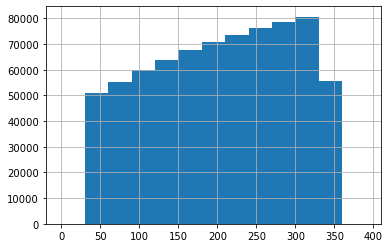

In [11]:
t = df_chunked['time'].compute()
print(t.max())
t.hist(bins=np.arange(0,400,30))

In [12]:
# bin geographically
lat_bins = np.arange(-60, 60, 1.)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['time','lon','lat'])
              .reset_index(), id_vars=['lat_cut',], var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')

# store diagnostic (not done here)
#p.store_diagnostic('spectra_lat', ds, overwrite=True)

# may be loaded with 
#ds = p.load_diagnostic('spectra_lat.zarr')

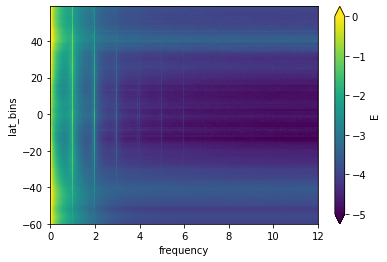

In [13]:
np.log10(ds.E).plot(vmin=-5., vmax=0.)

## Close cluster

In [ ]:
cluster.scale(jobs=10)

In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
